**Importing Libraries** and **Installing Dependencies**

In [22]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Importing Datasets**

In [23]:
dataset = yf.download("GC=F", start="2019-01-01", end="2023-07-19")
dataset

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1286.000000,1286.000000,1277.599976,1281.000000,1281.000000,149
2019-01-03,1286.800049,1292.000000,1286.699951,1291.800049,1291.800049,10
2019-01-04,1294.199951,1294.199951,1275.300049,1282.699951,1282.699951,34
2019-01-07,1286.800049,1286.800049,1286.599976,1286.800049,1286.800049,2
2019-01-08,1280.500000,1283.199951,1278.199951,1283.199951,1283.199951,54
...,...,...,...,...,...,...
2023-07-12,1932.300049,1958.000000,1932.199951,1956.199951,1956.199951,132
2023-07-13,1961.099976,1961.099976,1953.000000,1959.199951,1959.199951,121
2023-07-14,1958.400024,1960.599976,1952.699951,1960.099976,1960.099976,94


**Dropping Unused Column / Data Reduction**

In [24]:
dataReduct = dataset
to_drop = ['Open',	'High',	'Low',	'Adj Close', 'Volume']
dataReduct.drop(to_drop, inplace=True, axis=1)
dataReduct

,Close
Date,
2019-01-02,1281.000000
2019-01-03,1291.800049
2019-01-04,1282.699951
2019-01-07,1286.800049
2019-01-08,1283.199951
...,...
2023-07-12,1956.199951
2023-07-13,1959.199951
2023-07-14,1960.099976


In [25]:
df = pd.DataFrame(dataReduct)
df.to_csv('data aktual.csv', index=False)

**Normalize Data**

In [26]:
dataReduct = dataReduct.values
scaler = MinMaxScaler()
dataScaled = scaler.fit_transform(dataReduct)
dataScaled

array([[0.01495775],
       [0.02876502],
       [0.01713104],
       ...,
       [0.88315005],
       [0.87330608],
       [0.90501144]])

Create **Data Train** and **Data Test** to separate them to make the model

In [27]:
time_steps = 1 # How many days are used to look back for predict the next day

training_data_len = math.ceil(len(dataReduct) * .8) # Length Data

data_train = dataScaled[0:training_data_len, :]
data_test = dataScaled[training_data_len - time_steps: , :]

X_train = []
y_train = []

Nilai_prediksi = []
Nilai_aktual = dataReduct[training_data_len:, :]

for i in range(time_steps, len(data_train)):
  X_train.append(data_train[i-time_steps:i, 0])
  y_train.append(data_train[i, 0])

for i in range(time_steps, len(data_test)):
  Nilai_prediksi.append(data_test[i-time_steps:i, 0])

**Convert** data to numpy array and **Reshaping** a NumPy array with 1 feature.

In [28]:
features = 1 # column

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], features))

Nilai_prediksi = np.array(Nilai_prediksi)
Nilai_prediksi = np.reshape(Nilai_prediksi, (Nilai_prediksi.shape[0], Nilai_prediksi.shape[1], features))

In [29]:
X_train.shape

(914, 1, 1)

In [30]:
Nilai_prediksi.shape

(228, 1, 1)

In [31]:
tf.random.set_seed(10)

Model **LSTM** & **Bi-LSTM** and **Evaluation + Output**

In [32]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

outputs_rmse_lstm = []
outputs_mape_lstm = []
outputs_r_squared_lstm = []
outputs_rmse_bilstm = []
outputs_mape_bilstm = []
outputs_r_squared_bilstm = []

validation_lstm_list = []
validation_bilstm_list = []

for _ in range(5):
    # LSTM Model
    model_lstm = Sequential([(layers.LSTM(50)), layers.Dense(25),
                              layers.Dense(1)])

    model_lstm.compile(loss='mse', optimizer=Adam())
    model_lstm.fit(X_train, y_train, epochs=1, batch_size=1)

    # Bi-LSTM Model
    model_bilstm = Sequential([layers.Bidirectional(layers.LSTM(50)), layers.Dense(25),
                          layers.Dense(1)])

    model_bilstm.compile(loss='mse', optimizer=Adam())
    model_bilstm.fit(X_train, y_train, epochs=1, batch_size = 1)

    # Evaluate & Denormalization LSTM and Bi-LSTM
    result_lstm = model_lstm.evaluate(Nilai_prediksi, Nilai_aktual)
    Predictions_lstm = model_lstm.predict(Nilai_prediksi)
    Predictions_lstm = scaler.inverse_transform(Predictions_lstm)

    result_bilstm = model_bilstm.evaluate(Nilai_prediksi, Nilai_aktual)
    Predictions_bilstm = model_bilstm.predict(Nilai_prediksi)
    Predictions_bilstm = scaler.inverse_transform(Predictions_bilstm)



8/8 [==============================] - 1s 5ms/step


In [33]:
    # Output untuk performa model
    rmse_lstm = np.sqrt(mean_squared_error(Nilai_aktual, Predictions_lstm))
    mape_lstm = mean_absolute_percentage_error(Nilai_aktual, Predictions_lstm)
    r_squared_lstm = r2_score(Nilai_aktual, Predictions_lstm)

    rmse_bilstm = np.sqrt(mean_squared_error(Nilai_aktual, Predictions_bilstm))
    mape_bilstm = mean_absolute_percentage_error(Nilai_aktual, Predictions_bilstm)
    r_squared_bilstm = r2_score(Nilai_aktual, Predictions_bilstm)

In [34]:
    outputs_rmse_lstm.append(rmse_lstm)
    outputs_mape_lstm.append(mape_lstm)
    outputs_r_squared_lstm.append(r_squared_lstm)

    outputs_rmse_bilstm.append(rmse_bilstm)
    outputs_mape_bilstm.append(mape_bilstm)
    outputs_r_squared_bilstm.append(r_squared_bilstm)

In [ ]:
    # Output untuk plot
    validation_lstm = dataset[training_data_len:]
    validation_lstm['Predictions_lstm'] = Predictions_lstm
    validation_bilstm = dataset[training_data_len:]
    validation_bilstm['Predictions_bilstm'] = Predictions_bilstm

    validation_lstm_list.append(validation_lstm)
    validation_bilstm_list.append(validation_bilstm)

In [36]:
# Output Performa Model selama 5 kali pengujian
n = 1
t = 1
for x,y,z in zip(outputs_rmse_lstm, outputs_mape_lstm, outputs_r_squared_lstm):
  print("RMSE LSTM Pengujian", n, " :", x)
  print("MAPE LSTM Pengujian", n, " :", y)
  print("R_squared LSTM Pengujian", n, " :", z, "\n")
  n += 1

for x,y,z in zip(outputs_rmse_bilstm, outputs_mape_bilstm, outputs_r_squared_bilstm):
  print("RMSE Bi-LSTM Pengujian", t, " :", x)
  print("MAPE Bi-LSTM Pengujian", t, " :", y)
  print("R_squared Bi-LSTM Pengujian", t, " :", z, "\n")
  t += 1

RMSE LSTM Pengujian 1  : 25.35443794687796
MAPE LSTM Pengujian 1  : 0.011510188064159882
R_squared LSTM Pengujian 1  : 0.956384756925746 

RMSE Bi-LSTM Pengujian 1  : 28.194253589414338
MAPE Bi-LSTM Pengujian 1  : 0.013260226670506758
R_squared Bi-LSTM Pengujian 1  : 0.9460673791592145 



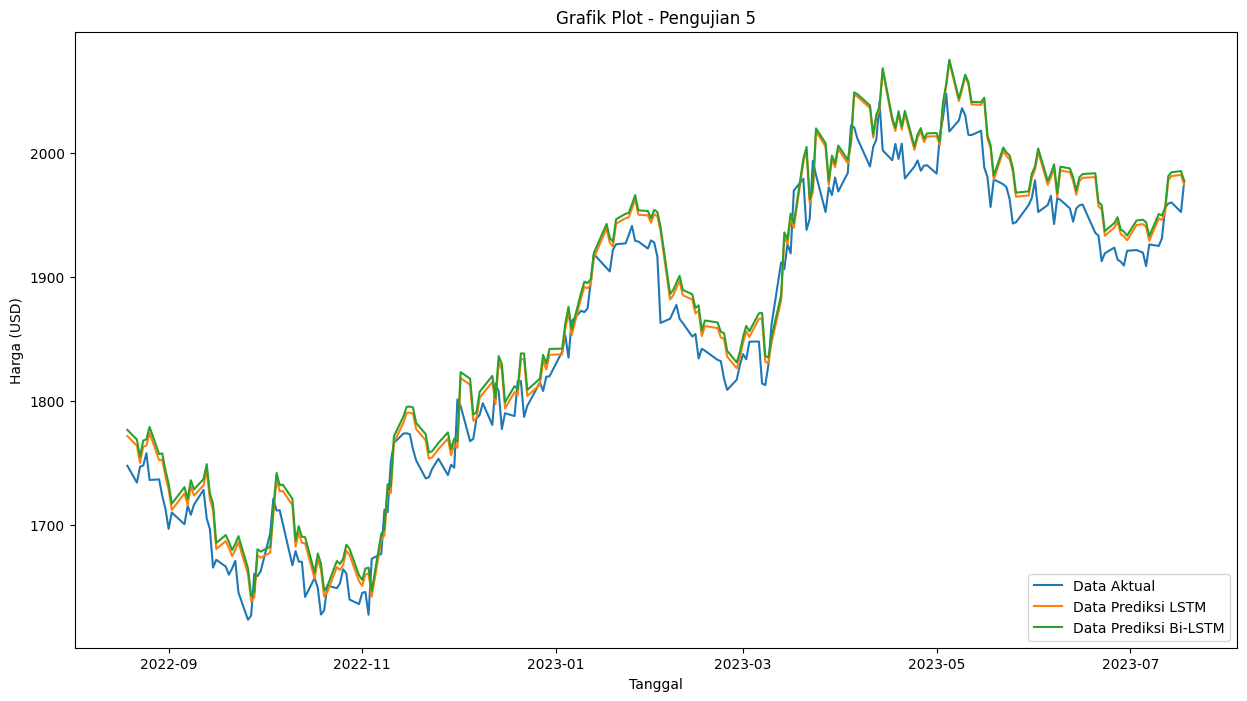

In [37]:
# Plot untuk 5 kali pengujian
n = 5
for df_lstm, df_bilstm in zip(validation_lstm_list, validation_bilstm_list):
    plt.figure(figsize=(15, 8))
    plt.title(f'Grafik Plot - Pengujian {n}')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga (USD)')

    # Plot actual data, LSTM predictions, and Bi-LSTM predictions
    plt.plot(df_lstm.iloc[:][['Close', 'Predictions_lstm']])
    plt.plot(df_bilstm.iloc[:][['Predictions_bilstm' ]])
    plt.legend(['Data Aktual', 'Data Prediksi LSTM', 'Data Prediksi Bi-LSTM'], loc='lower right')
    plt.show()

    n += 1

In [38]:
df_lstm.iloc[:][['Close', 'Predictions_lstm']]

,Close,Predictions_lstm
Date,,
2022-08-19,1747.599976,1771.563599
2022-08-22,1734.000000,1763.716431
2022-08-23,1746.800049,1749.872314
2022-08-24,1747.800049,1762.901611
2022-08-25,1757.699951,1763.920288
...,...,...
2023-07-12,1956.199951,1952.505371
2023-07-13,1959.199951,1978.322144
2023-07-14,1960.099976,1981.435791


Output Summary **Layers** and **Models** (LSTM)

In [39]:
print(model_lstm.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                10400     
                                                                 
 dense_20 (Dense)            (None, 25)                1275      
                                                                 
 dense_21 (Dense)            (None, 1)                 26        
                                                                 
Total params: 11701 (45.71 KB)
Trainable params: 11701 (45.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Output Summary **Layers** and **Models** (Bi-LSTM)

In [40]:
print(model_bilstm.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirecti  (None, 100)               20800     
 onal)                                                           
                                                                 
 dense_22 (Dense)            (None, 25)                2525      
                                                                 
 dense_23 (Dense)            (None, 1)                 26        
                                                                 
Total params: 23351 (91.21 KB)
Trainable params: 23351 (91.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [41]:
pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [42]:
# !cat /proc/cpuinfo
# !dataset -h
# !cat /proc/meminfo